# Machine learning for sentiment classification on movie reviews
This project aims at compare several classification algorithms and textual data representations with their parameters, on a dataset of movies reviews classified as positive or negative.
We experiment a representation as token counts (CountVectorizer) and 4 classification algorithms:
 - Multinomial Naive Bayes
 - Logistic regression
 - SVM
 - bi-directionnal LSTM

In [1]:
# load common librairies
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Load data
First the data is transformed into pandas dataframes by some file manipulation. We use the Polarity dataset v2.0 of [Bo Pang and Lillian Lee, ACL 2004], which is available at: http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

In [2]:
# load dedicated library
import os

In [3]:
# preprocessing: prepare data
col_names = ['content', 'label']
pos = pd.DataFrame(columns = col_names)
neg = pd.DataFrame(columns = col_names)

In [4]:
# add positive samples to the DataFrame structure
i=1
for fend in os.listdir('./dataset1/pos/'):
    #data = pd.read_csv('./dataset1/pos/'+fend, sep = None, header = None)
    file = open('./dataset1/pos/'+fend, 'r')
    data = file.read()
    #print(data)
    file.close()
    pos = pos.append(pd.DataFrame({'content':[data], 'label':int(1)}, index=[i]))
    i+=1
# add negative samples to the DataFrame structure
i=1
for fend in os.listdir('./dataset1/neg/'):
    #data = pd.read_csv('./dataset1/neg/'+fend, sep = None, header = None)
    file = open('./dataset1/neg/'+fend, 'r')
    data = file.read()
    file.close()
    neg = neg.append(pd.DataFrame({'content':[data],'label':int(-1)}, index=[i]))
    i+=1

In [5]:
# convert label to a numerical variable
#reviews["label_num"] = reviews.label.map({"1":int(1), "-1":int(0)})
pos["label_num"] = pos['label'].astype(int)
neg["label_num"] = neg['label'].astype(int)

In [6]:
# print
print('pre-processing done')
print('number of positive samples: {} '.format(len(pos)))
print('number of negative samples: {} '.format(len(neg)))
print()
print('last positive samples:')
print(pos.tail(5))
print()
print('last negative samples:')
print(neg.tail(5))

pre-processing done
number of positive samples: 1000 
number of negative samples: 1000 

last positive samples:
                                                content label  label_num
996   wow ! what a movie . \nit's everything a movie...     1          1
997   richard gere can be a commanding actor , but h...     1          1
998   glory--starring matthew broderick , denzel was...     1          1
999   steven spielberg's second epic film on world w...     1          1
1000  truman ( " true-man " ) burbank is the perfect...     1          1

last negative samples:
                                                content label  label_num
996   if anything , " stigmata " should be taken as ...    -1         -1
997   john boorman's " zardoz " is a goofy cinematic...    -1         -1
998   the kids in the hall are an acquired taste . \...    -1         -1
999   there was a time when john carpenter was a gre...    -1         -1
1000  two party guys bob their heads to haddaway's d...    -1

## Prepare learning datasets
Then we mix the 2 dataframes of positive and negative samples into 2 random dataframes dedicated to training and testing. We verified that the random split was always done in the same way (with the same seed) to ensure that the results are the same every time we run the code.

In [7]:
# concat positive and negative samples
reviews = pos.append(neg)

In [8]:
# define X (items) and y (labels)
X = reviews.content
y = reviews.label_num

In [9]:
# split randomly X and y into train and test sets (NB: always uses the same seed)
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

In [10]:
# print
print('number of train samples: {}'.format(len(X_train)))
print('number of test samples: {}'.format(len(X_test)))
print()
print('first train samples with their labels:')
print(X_train.head(10))
print(y_train.head(10))
#print()
#print('first test samples with their labels:')
#print(X_test.head(10))
#print(y_test.head(10))

number of train samples: 1500
number of test samples: 500

first train samples with their labels:
651    james cmaeron's breakthrough feature was the f...
105    this is not a simple plan about finding a plan...
562    the seasoned capt . dudley smith ( james cromw...
644    in `enemy at the gates' , jude law is a gifted...
442    call me crazy , but i don't see saving private...
629    writer/director lawrence kasdan had a hand in ...
997    john boorman's " zardoz " is a goofy cinematic...
681    it is an understood passion and an understood ...
813    seen april 16 , 1999 at 10 p . m . at crossgat...
505    american pie 2 is filled with laughs . \nbut t...
Name: content, dtype: object
651    1
105   -1
562    1
644    1
442    1
629   -1
997   -1
681    1
813    1
505   -1
Name: label_num, dtype: int32


 ## Representing text as numerical data (vectorization)
In order to use text as input of the classification algorithms, we need to convert it into fixed-size numerical feature vectors. To do so we use scikit-learn CountVectorizer that "converts text into a matrix of token counts", or "bag of words". It first learns the vocabulary over the text given as input, and then transforms any textual data into a document-term matrix using the fitted vocabulary. We learn the vocabulary on the training dataset, and compute the document-term matrix representations for both training and testing data. The basic method uses the input token as such in the vocabulary, but it's also possible to use methods of natural language processing to use more elaborated tokens.

In [11]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [12]:
# learn the "vocabulary" of the training data (occurs in-place)
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
# examine the fitted vocabulary
vocabulary = vect.get_feature_names()
print('number of words in the vocabulary: {} '.format(len(vocabulary)))
vocabulary

number of words in the vocabulary: 35152 


['00',
 '000',
 '0009f',
 '007',
 '00s',
 '03',
 '04',
 '05',
 '05425',
 '10',
 '100',
 '1000',
 '10000',
 '100m',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '10s',
 '10th',
 '11',
 '110',
 '111',
 '112',
 '113',
 '1138',
 '114',
 '115',
 '117',
 '118',
 '11th',
 '12',
 '121',
 '122',
 '123',
 '125',
 '126',
 '127',
 '1272',
 '128',
 '129',
 '1298',
 '13',
 '130',
 '1305',
 '132',
 '133',
 '135',
 '137',
 '138',
 '13th',
 '14',
 '143',
 '14th',
 '15',
 '150',
 '1500s',
 '151',
 '152',
 '153',
 '155',
 '1583',
 '15th',
 '16',
 '160',
 '1600',
 '1600s',
 '161',
 '167',
 '1692',
 '16mm',
 '16x9',
 '17',
 '170',
 '1700s',
 '1709',
 '172',
 '175',
 '1773',
 '1791',
 '1792',
 '1793',
 '1794',
 '1799',
 '17th',
 '18',
 '180',
 '1800',
 '1800s',
 '1812',
 '1830s',
 '1839',
 '1847',
 '1862',
 '1865',
 '1869',
 '1871',
 '1885',
 '1888',
 '189',
 '1896',
 '1898',
 '18s',
 '18th',
 '19',
 '1900',
 '1900s',
 '1903',
 '1912',
 '1914',
 '1916',
 '1919',
 '1920s',
 '1922'

In [14]:
# transform training data into a "document-term matrix'
X_train_dtm = vect.transform(X_train)
X_train_dtm

<1500x35152 sparse matrix of type '<class 'numpy.int64'>'
	with 495843 stored elements in Compressed Sparse Row format>

In [15]:
# examine the content of the sparse matrix
print(X_train_dtm)

  (0, 175)	5
  (0, 206)	3
  (0, 586)	1
  (0, 607)	3
  (0, 1062)	2
  (0, 1280)	3
  (0, 1330)	1
  (0, 1332)	1
  (0, 1348)	3
  (0, 1470)	1
  (0, 1509)	1
  (0, 1548)	13
  (0, 1659)	2
  (0, 1670)	1
  (0, 1760)	1
  (0, 1856)	1
  (0, 1919)	6
  (0, 1975)	1
  (0, 1995)	2
  (0, 2022)	1
  (0, 2024)	1
  (0, 2036)	1
  (0, 2076)	2
  (0, 2233)	3
  (0, 2461)	1
  :	:
  (1499, 34370)	1
  (1499, 34385)	4
  (1499, 34395)	1
  (1499, 34417)	1
  (1499, 34421)	1
  (1499, 34423)	1
  (1499, 34494)	1
  (1499, 34580)	1
  (1499, 34592)	9
  (1499, 34605)	1
  (1499, 34649)	1
  (1499, 34704)	1
  (1499, 34708)	1
  (1499, 34712)	1
  (1499, 34724)	2
  (1499, 34743)	1
  (1499, 34753)	1
  (1499, 34757)	1
  (1499, 34798)	1
  (1499, 34821)	2
  (1499, 34861)	1
  (1499, 34927)	2
  (1499, 34995)	18
  (1499, 35003)	7
  (1499, 35006)	1


In [16]:
# examine the vocabulary and document-term matrix together (X_train_dtm.toarray() converts sparse matrix to a dense matrix)
pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())

,00,000,0009f,007,00s,03,04,05,05425,10,...,zucker,zuehlke,zuko,zulu,zurg,zus,zweibel,zwick,zwigoff,zycie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<500x35152 sparse matrix of type '<class 'numpy.int64'>'
	with 165969 stored elements in Compressed Sparse Row format>

## Class prediction with Multinomial Naive Bayes
The first classifier we test here is a classical one for textual data represented as bag of words, and the combination of these two was a reference until the explosion of deep learning. So it's a good start to have a feeling of the performance we can get on our dataset. The use is really simple with scikit-learn, since it stands in 3 lines for the training and 1 line for a prediction on test data. More, this method has the advantage to have really low computation time, and not to require lots of training data like deep learning methods. It has 3 parameters (from scikit-learn documentation):
 - alpha: additive (Laplace/Lidstone) smoothing parameter (default=1.0, 0 for no smoothing)
 - fit_prior: whether to learn class prior probabilities or not. If false, a uniform prior will be used (default=True)
 - class_prior: enables to give one's own prior probabilities to the classes. If specified the priors are not adjusted according to the data (default=None)

Here we already know that the 2 classes are equaly distributed, so the fit_prior parameter has no impact: we will get the same results by computing prior probabilities or by imposing a uniform distribution. And we don't try other priors either as it would give worse results. However alpha has a real impact that we evaluate in the next.

In [18]:
# import scikit-learn library
from sklearn.naive_bayes import MultinomialNB

In [19]:
# instantiate a Multinomial Naive Bayes model
alpha = 2 #(default=1.0, 0 for no smoothing)
MNB = MultinomialNB(alpha, False)

In [20]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time MNB.fit(X_train_dtm, y_train)

Wall time: 80.8 ms


MultinomialNB(alpha=2, class_prior=None, fit_prior=False)

In [21]:
# make class predictions for X_test_dtm
y_pred_class = MNB.predict(X_test_dtm)

### Performance evaluation
We evaluate each classifier with common metrics: accuracy and area under ROC curve, and also compute the confusion matrix.

In [22]:
# calculate accuracy of class predictions
accuracy_MNB = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy_MNB))

accuracy is: 0.808


In [23]:
# calculate predicted probabilities for X_test_dtm and AUC
y_pred_prob = MNB.predict_proba(X_test_dtm)[:, 1]
AUC_MNB = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC_MNB,3)))

area under ROC curve is: 0.884


In [24]:
# print the confusion matrix
conf_mat_MNB = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat_MNB)

confusion matrix is:
[[195  50]
 [ 46 209]]


In [25]:
# print reviews for the false positives
FP_MNB = X_test[(y_pred_class==1) & (y_test==-1)]
print('there are {} false positive samples:'.format(len(FP_MNB)))
print(FP_MNB)

there are 50 false positive samples:
211    the rich legacy of cinema has left us with cer...
683    often similar to a little boy lost in a park t...
822    it's difficult to expect much from a director ...
927    star wars : ? episode i -- the phantom menace ...
762    weighed down by tired plot lines and spielberg...
481    as any reasonable human being would , i must a...
87     lucas was wise to start his star wars trilogy ...
315    since director steven zaillian previously wrot...
238    there is a scene early in jakob the liar that ...
541    whether or not i would be considered a trekker...
244    i read the new yorker magazine and i enjoy som...
110    nearly every film tim burton has directed has ...
552    kate ( jennifer aniston ) is having some probl...
168    so , it's thirty years later , and oscar and f...
263    it's not a bad thing to update old stories . \...
603    by phil curtolo " madonna - antonio banderas -...
216    libby parsons ( ashley judd ) has the perfec

In [26]:
# print reviews for the false negatives
FN_MNB = X_test[(y_pred_class==-1) & (y_test==1)]
print('there are {} false negative samples:'.format(len(FN_MNB)))
print(FN_MNB)

there are 46 false negative samples:
859    mike myers , you certainly did throw us a ? fr...
882    the word 'rest' in the title should be stresse...
283    ok , let's get one thing straight right away :...
694    let me first say that the conditions that i wa...
656    jacques tati's 1953 classic " les vacances de ...
127    i have to say it . \ntim burton's retelling of...
237    jerry springer has got nothing on " wild thing...
373    okay , let me first say , this is a beavis and...
995    a thriller set in modern day seattle , that ma...
987    i think the first thing this reviewer should m...
701    let me start off by saying that leading up to ...
556    harmless , silly and fun comedy about dim-witt...
762    film adaptation of hunter s . thompson's infam...
349    bob the happy bastard's quickie review : \nthe...
481    the trailers and the beginning of the move sum...
511    are we victims of fate in life or can we creat...
390    when i left the theater after seeing david l

### Parameter tuning with cross-validation
We evaluate the impact of the parameter alpha and try to find the best value with grid search cross-validation.

In [27]:
# define the parameters
alpha_range = [1.0e-10, 0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8] #0 not accepted in MultinomialNB and automatically mapped to 1.0e-10
param_grid = dict(alpha=alpha_range)

In [28]:
# operate grid search with default RBF kernel
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=3, return_train_score=True)
grid.fit(X_train_dtm, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-10, 0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
# print results
print("The best alpha is %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score']
scores

The best alpha is {'alpha': 2} with a score of 0.81


array([0.68733333, 0.78333333, 0.79066667, 0.796     , 0.80733333,
       0.81266667, 0.806     , 0.786     , 0.75866667, 0.72333333])

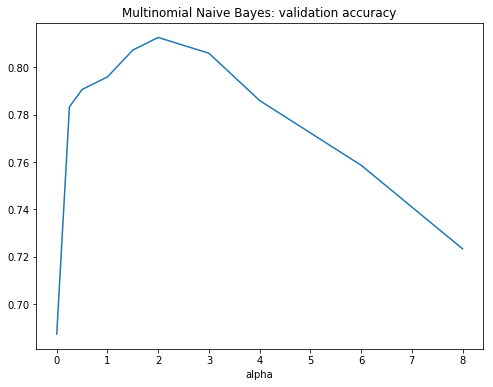

In [30]:
# plot scores
plt.figure(figsize=(8, 6))
plt.plot(alpha_range, scores)
plt.xlabel('alpha')
plt.title('Multinomial Naive Bayes: validation accuracy')
plt.show()

## Class prediction with logistic regression
A second common classification method is logistic regression, which is also provided by scikit-learn. The main parameters are (from scikit-learn documentation):
 - solver: algorithm to use in the optimization problem, among ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ (default: ‘liblinear’, but will be changed to 'lbfgs' in scikit-learn v0.22)
 - max_iter: maximum number of iterations taken for the solvers ‘newton-cg’, ‘sag’ and ‘lbfgs’ to converge
 - penalty: norm used in the penalization (‘l1’ or ‘l2’, default: ‘l2’).
 - dual: use of dual or primal formulation (default: False). Dual formulation is only implemented for l2 penalty.
 - tol: tolerance for stopping criteria (default: 1e-4)
 - C: inverse of regularization strength (default: 1.0). Like in SVMs, smaller values specify stronger regularization.
 - fit_intercept: whether a constant (a.k.a. bias or intercept) should be added to the decision function (default: True)
 - 


In [31]:
# import and instantiate a logistic regression model 
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [32]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

Wall time: 705 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

### Performance evaluation

In [34]:
# calculate accuracy
accuracy_LogReg = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy_LogReg))

accuracy is: 0.842


In [35]:
# calculate predicted probabilities for X_test_dtm and area under ROC curve
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
AUC_LogReg = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC_LogReg,3)))

area under ROC curve is: 0.912


In [36]:
# print the confusion matrix
conf_mat_LogReg = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat_LogReg)

confusion matrix is:
[[211  34]
 [ 45 210]]


### Test with another solver
Default solver will be changed to 'lbfgs' in scikit-learn v0.22. So it may be useful to try it.

In [37]:
# instantiate a logistic regression model 
logreg = LogisticRegression(solver='lbfgs', max_iter=300)

In [38]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

Wall time: 2.97 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [40]:
# calculate accuracy
accuracy_LogReg = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy is: {}'.format(accuracy_LogReg))

accuracy is: 0.836


In [41]:
# calculate predicted probabilities for X_test_dtm and area under ROC curve
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
AUC_LogReg = metrics.roc_auc_score(y_test, y_pred_prob)
print('area under ROC curve is: {}'.format(round(AUC_LogReg,3)))

area under ROC curve is: 0.912


In [42]:
# print the confusion matrix
conf_mat_LogReg = metrics.confusion_matrix(y_test, y_pred_class)
print('confusion matrix is:')
print(conf_mat_LogReg)

confusion matrix is:
[[210  35]
 [ 47 208]]


### Tuning parameters with cross-validation

In [ ]:
C_range = np.logspace(0, 10, 6)
gamma_range = np.logspace(-9, -1, 5)
param_grid = dict(gamma=gamma_range, C=C_range)

In [ ]:
# operate grid search
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3, return_train_score=True)
grid.fit(X_train_dtm, y_train)

In [ ]:
# print results
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
scores

In [ ]:
# draw heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## Class prediction with SVM

In [ ]:
# import, instantiate and train a SVM model without probability estimation
from sklearn.svm import SVC
clf = SVC(kernel='linear')
%time clf.fit(X_train_dtm, y_train)

In [ ]:
# make class predictions for X_test_dtm
y_pred_class = clf.predict(X_test_dtm)

### Performance evaluation

In [ ]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

In [ ]:
# import, instantiate and train a SVM model with probability estimation
clf = SVC(kernel='linear', probability=True)
%time clf.fit(X_train_dtm, y_train)

In [ ]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = clf.predict_proba(X_test_dtm)[:, 1]

In [ ]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

### Tuning parameters with cross-validation

In [ ]:
# 1st step: large logarithmic grid search
C_range = np.logspace(0, 10, 6)
gamma_range = np.logspace(-9, -1, 5)
param_grid = dict(gamma=gamma_range, C=C_range)

In [ ]:
# operate grid search with default RBF kernel
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3, return_train_score=True)
grid.fit(X_train_dtm, y_train)

In [ ]:
# print results
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
scores

In [ ]:
# draw heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [ ]:
# 2nd step: precise logarithmic grid search on selected range
C_range = np.logspace(4, 8, 5)
gamma_range = np.logspace(-8, -4, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(kernel='linear'), param_grid=param_grid)
param_grid

In [ ]:
# operate grid search with default RBF kernel
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3, return_train_score=True)
grid.fit(X_train_dtm, y_train)

In [ ]:
# print results
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
scores

In [ ]:
# draw heatmap
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## Class prediction using bidirectional LSTM

In [ ]:
print(y_train.values.reshape(1, y_train.shape[0], 1))

In [ ]:
print(X_train_dtm.toarray().reshape(1, X_train_dtm.shape[0], X_train_dtm.shape[1]))

In [44]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

#on fixe la seed utilisée par LSTM()
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


y_tr = [y_train.values.reshape(1, y_train.shape[0], 1).tolist()]
y_ts = [y_test.values.reshape(1, y_test.shape[0], 1).tolist()]

X_tr = X_train_dtm.toarray()
X_ts = X_test_dtm.toarray()

X_tr = np.reshape(X_tr, X_tr.shape + (1,))
X_ts = np.reshape(X_ts, X_ts.shape + (1,))


X_tr = np.transpose(X_tr, (0, 2, 1))
X_ts = np.transpose(X_ts, (0, 2, 1))

print(X_tr.shape)
print(y_tr)

#https://stackoverflow.com/questions/44273249/in-keras-what-exactly-am-i-configuring-when-i-create-a-stateful-lstm-layer-wi

#dans un terminal, nous pouvons ensuite lancer tensorboard de cette façon:
#    tensorboard --logdir path_to_current_dir/Graph 

#on crée le tensorflow callback pour la visualisation dans le terminal avec tensorboard
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=X_tr.shape[1:], merge_mode='concat'))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Entrainement
for epoch in range(250):
    model.fit(X_tr, y_tr, epochs=1, batch_size=1, verbose=2, callbacks=[tbCallBack])
    
#Accuracy
score = model.evaluate(X_ts, y_ts, batch_size=1)
print(score)

(1500, 1, 35604)
[[[[1], [-1], [1], [1], [1], [-1], [-1], [1], [1], [-1], [-1], [1], [1], [-1], [-1], [1], [-1], [-1], [1], [1], [1], [1], [1], [-1], [-1], [1], [-1], [1], [1], [1], [-1], [-1], [1], [1], [1], [1], [1], [1], [-1], [-1], [-1], [1], [-1], [1], [-1], [1], [-1], [1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [1], [-1], [-1], [-1], [1], [-1], [1], [-1], [-1], [-1], [-1], [1], [1], [1], [1], [-1], [-1], [1], [-1], [-1], [-1], [1], [1], [1], [-1], [-1], [-1], [1], [1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [1], [-1], [-1], [1], [1], [1], [-1], [-1], [-1], [-1], [1], [-1], [1], [1], [1], [1], [1], [1], [-1], [1], [1], [-1], [1], [-1], [-1], [1], [1], [1], [-1], [-1], [-1], [-1], [1], [-1], [-1], [-1], [-1], [1], [1], [1], [1], [-1], [-1], [1], [1], [-1], [1], [-1], [-1], [-1], [1], [-1], [1], [1], [-1], [-1], [-1], [-1], [1], [1], [1], [-1], [1], [-1], [1], [-1], [1], [-1]

ValueError: Error when checking target: expected time_distributed_17 to have shape (1, 1) but got array with shape (1500, 1)